In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import njit, prange
from scipy.misc import derivative
import cupy as cp
import seaborn as sns
import scipy.stats as st
from tqdm import tqdm
import time
from scipy.linalg import sqrtm
from scipy.optimize import fsolve
import warnings
warnings.filterwarnings("ignore")

### **1. Apple-Orange choice of a HH**
###### **Consider a household that maximizes preference $$\large U = (\alpha \, X^{\large 1-\dfrac{1}{\eta}} + (1-\alpha)\, Y^{\large 1-\dfrac{1}{\eta}})^{\large \dfrac{\eta}{\eta - 1}} $$ subject to the B.C. $$\large pX + qY = I$$ where $X$ , $Y$ are apple and orange consumed by a household.**
##### **1.1. Solve the HH problem analytically.**
###### $\begin{cases} \huge U_x = g_x \implies common\_term \; \cdot \alpha \cdot X^{\frac{-1}{\eta}} = \lambda \cdot p \\ \\ \huge U_y = g_y \implies common\_term \; \cdot (1 - \alpha) \cdot Y^{\frac{-1}{\eta}} = \lambda \cdot q \\ \\ \huge X = \dfrac{I - qY}{p} \end{cases} \implies \huge (\dfrac{Y}{X}) = (\dfrac{p(1-\alpha)}{\alpha q})^\eta = S\implies Y = XS = \dfrac{I - qY}{p} S$ 

###### To summarize $$\huge \begin{cases} S = (\dfrac{p(1-\alpha)}{\alpha q})^\eta \\ \\ Y^* = \dfrac{I}{\dfrac{p}{S} + q} \\ \\   X^* = \dfrac{Y^*}{S} \end{cases}$$ 

##### **1.2. Now we want to simulate the economy. Suppose $\eta$ and $I$ both have log-normal distributions with parameters $\large \mu_{\eta}, \; \sigma_{\eta}, \; \mu_{I}, \; \sigma_{I}$ . Simulate household $i$'s behavior.**

##### **1.3. Calculate the aggregate consumption of apples and oranges in the economy. How do they depend on $\large \mu_{\eta}, \; \sigma_{\eta}, \; \mu_{I}, \; \sigma_{I}$.**

##### **1.4. Plot the distributions of consumptions of apples.**

In [159]:
def apple_orange_choice(mu_eta = 0, sigma_eta = 1, mu_i = 10, sigma_i = 1, n = int(1e5), p = 2 , q = 3, alpha = 0.6):
    
    apple_consumption = cp.zeros(n)
    orange_consumption = cp.zeros(n)
    
    for i in tqdm(range(n)):
        eta = cp.random.lognormal(mu_eta, sigma_eta, 1, dtype = np.float32)
        income = cp.random.lognormal(mu_i, sigma_i, 1, dtype = np.float32)
        S = ((p * (1 - alpha))/(alpha * q)) ** eta
        orange = income / ((p/S) + q)
        apple = orange / S 
        apple_consumption[i] = apple
        orange_consumption[i] = orange

    apple_consumption = apple_consumption[~cp.isnan(apple_consumption)]
    orange_consumption = orange_consumption[~cp.isnan(orange_consumption)]

    plt.subplot(1,2,1)
    sns.histplot(apple_consumption.get(), color='red', binrange = (0,60_000))
    plt.title(f'Consumption of Apple: {apple_consumption.get().mean():.3f}', fontsize=10)
    plt.subplot(1,2,2)
    sns.histplot(orange_consumption.get(), color='orange', binrange = (0,20_000))
    plt.title(f'Consumption of Orange: {orange_consumption.get().mean():.3f}', fontsize=10)
    plt.gcf().set_size_inches(10,4)
    plt.suptitle(f' $\mu_\eta$ = {mu_eta} ,  $\sigma_\eta$ = {sigma_eta}\n $\mu_I$ = {mu_i} , $\sigma_I$ = {sigma_i} ', y=1.1)
    plt.show() 

    return apple_consumption , orange_consumption

100%|██████████| 100000/100000 [00:13<00:00, 7225.17it/s]


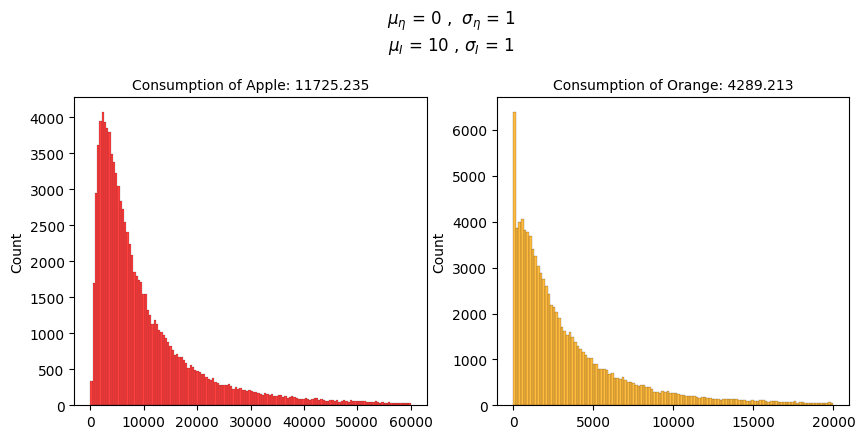

In [160]:
apple_consumption , orange_consumption = apple_orange_choice()

100%|██████████| 10000/10000 [00:01<00:00, 6965.33it/s]


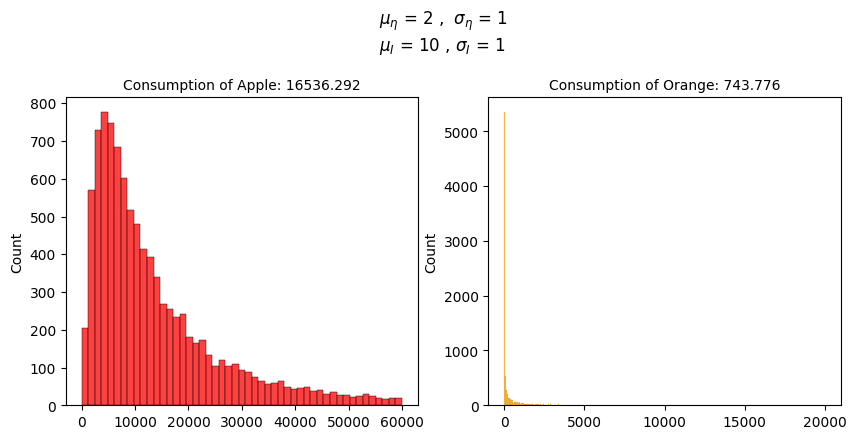

In [ ]:
apple_consumption , orange_consumption = apple_orange_choice(mu_eta = 2, n = 10_000) #Increasing elasticity leads to higher consumption of apple, which in our scenario has more preference and less proce as well

100%|██████████| 10000/10000 [00:01<00:00, 7803.95it/s]


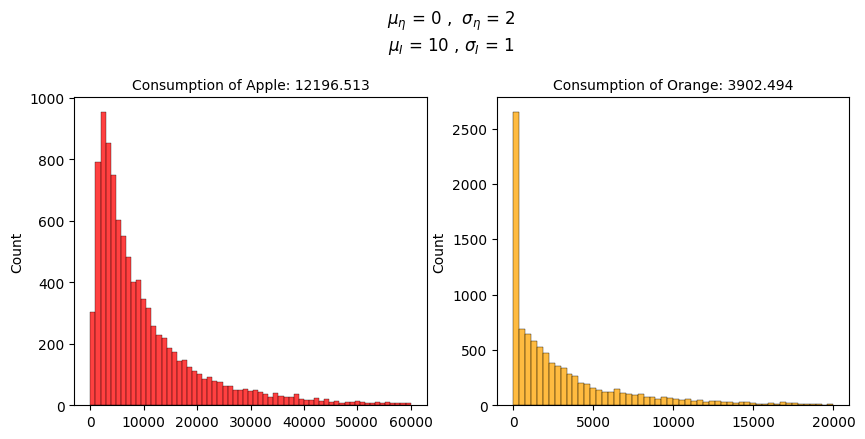

In [ ]:
apple_consumption , orange_consumption = apple_orange_choice(sigma_eta = 2, n = 10_000) 

100%|██████████| 10000/10000 [00:01<00:00, 7216.64it/s]


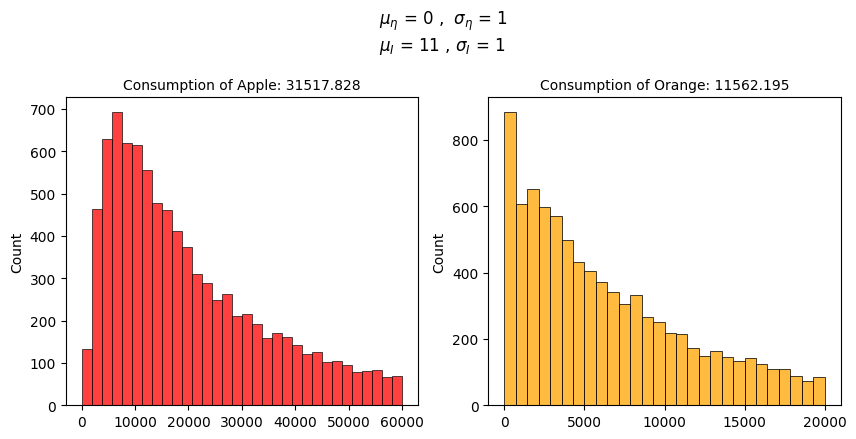

In [ ]:
apple_consumption , orange_consumption = apple_orange_choice(mu_i = 11, n = 10_000) #higher income increases overall consumption

In [166]:
def apple_orange_choice_avg(mu_eta = 0, sigma_eta = 1, mu_i = 10, sigma_i = 1, n = int(1e5), k = int(1e5), p = 2 , q = 3, alpha = 0.6):
    
    apple_consumption = cp.zeros(k)
    orange_consumption = cp.zeros(k)
    
    for i in tqdm(range(k)):
        eta = cp.random.lognormal(mu_eta, sigma_eta, n)
        income = cp.random.lognormal(mu_i, sigma_i, n)
        S = ((p * (1 - alpha))/(alpha * q)) ** eta
        orange = income / ((p/S) + q)
        apple = orange / S 

        apple = apple[~cp.isnan(apple)]
        orange = orange[~cp.isnan(orange)]

        apple_consumption[i] = apple.mean()
        orange_consumption[i] = orange.mean()
   
    apple_consumption = apple_consumption[~cp.isnan(apple_consumption)]
    orange_consumption = orange_consumption[~cp.isnan(orange_consumption)]
    
    plt.subplot(1,2,1)
    sns.histplot(apple_consumption.get(), color='red')
    plt.title(f'Consumption of Apple: {apple_consumption.get().mean():.3f}', fontsize=10)
    plt.subplot(1,2,2)
    sns.histplot(orange_consumption.get(), color='orange')
    plt.title(f'Consumption of Orange: {orange_consumption.get().mean():.3f}', fontsize=10)
    plt.gcf().set_size_inches(10,4)
    plt.suptitle(f' $\mu_\eta$ = {mu_eta} ,  $\sigma_\eta$ = {sigma_eta}\n $\mu_I$ = {mu_i} , $\sigma_I$ = {sigma_i} ', y=1.1)
    plt.show()    
    
    return apple_consumption , orange_consumption

100%|██████████| 100000/100000 [01:00<00:00, 1658.43it/s]


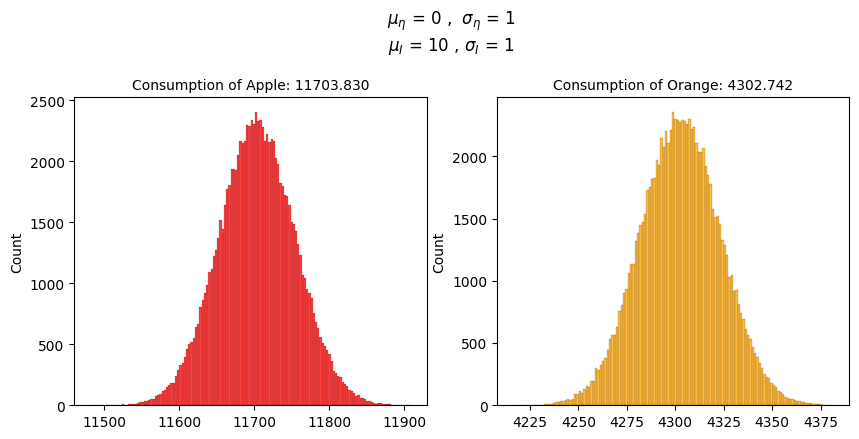

(array([11704.03594365, 11743.81282448, 11730.05279158, ...,
        11689.47819236, 11726.78075854, 11657.12581538]),
 array([4290.65490738, 4330.30191797, 4303.37827402, ..., 4295.41927783,
        4316.60959374, 4297.84969714]))

In [167]:
apple_orange_choice_avg()

100%|██████████| 10000/10000 [00:04<00:00, 2038.61it/s]


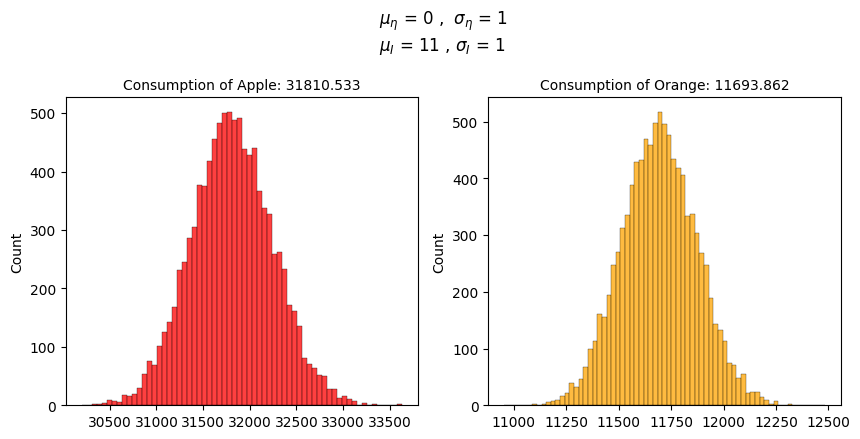

In [169]:
apple_consumption , orange_consumption = apple_orange_choice_avg(mu_i = 11, n = 10_000, k = 10_000)

### **2. Monte-Carlo Simulation**

###### **We will later study Monte-Carlo simulations and their applications in this course. But here we just want to introduce this useful method. Statistical inference (significance levels and hypothesis testing) relies heavily on asymptotic properties of estimators. Most of the important results are actually implications of Law of Large Numbers (LLN) and Central Limit Theorem (CLT) that we studied in the first problem set. I hope that you are convinced that LLN and CLT actually hold in practice, but then may need really large numbers. For small samples analytical results are rarely available, aside from tests of linear restrictions in the linear regression model under normality. Small-sample results can nonetheless be obtained by performing a Monte Carlo study. In this exercise we simulate a simple Monte Carlo study to depict small sample properties of an OLS estimator. Our goal is to first see how Monte Carlo simulations work and then to assure that asymptotic properties of OLS are actually work, but in asymptotic sense!**

##### **2.1 Small-Sample Properties**
###### **Imagine the true data generating process is $\large y = 1 + 2x_1 - 3x_2 + \epsilon$ Each time we draw $x$ and $y$ variables, estimated $\beta$ parameters are themselves random variables. Assume $\large x_1 \sim N(5, 2), \; x_2 \sim Binomial(8, 0.3) \text{ and   } \epsilon \sim N(0, 1)$. What is the mean and standard deviation of these random variables? (Hint: short answer is that we don't know!) Why are we interested in these statistics? Monte Carlo simulation is a solution to find properties of the estimators. Here is how to run MC simulation: For $R = 10,000$ times, draw a sample of size $N = 60$ observations from this DGP. Then use OLS to estimate parameters of the model, $(\beta_0, \; \beta_1, \; \beta_2)$, while we know that the true parameters are $(1, 2, -3)$. Then draw histogram of your estimated parameters and compare them with expected normal distribution. Even for this very simple model, it is not easy to compute small sample properties of the OLS estimators. You need all regressors to be distributed normally to have nice distribution. What is the implied distribution of the estimators in this example? Compare the simulated distributions with Normal distribution. In general, it would be impossible to compute small sample properties of more complicated estimators. These so called "Monte-Carlo simulations" help us to calculate not only mean and standard deviation of estimators, but the complete distribution of estimators.**

In [320]:
def small_sample_monte_carlo(r=int(1e4), n=60, plot=True):
    
    b_s = cp.zeros((r, 3))

    for i in tqdm(range(r)):
        x_0 = cp.ones((n,1))
        x_1 = cp.random.normal(5, cp.sqrt(2), n)
        x_2 = cp.random.binomial(8, 0.3, n)
        e = cp.random.normal(0,1,n)
        y = 1 + 2*x_1 - 3*x_2 + e
        x = cp.concatenate((x_0 , x_1.reshape(-1,1), x_2.reshape(-1,1)), axis=-1)
        y = y.reshape(-1,1)
        b = cp.linalg.inv(x.T @ x) @ (x.T @ y)
        b_s[i] = b.flatten()
    
    if plot:
        plt.subplot(1,3,1)
        sns.histplot(b_s[:,0].get(), kde = True,  label=r'$\beta_0$', color='blue')
        plt.legend()
        plt.title(f' $ \\beta_0:  Mean = {b_s[:,0].get().mean():.4f}  \; \; \; Std = {b_s[:,0].get().std():.4f} $ ', fontsize = 10)
        
        
        plt.subplot(1,3,2)
        sns.histplot(b_s[:,1].get(), kde = True,  label=r'$\beta_1$', color='red')
        plt.legend()
        plt.title(f' $ \\beta_1:  Mean = {b_s[:,1].get().mean():.4f}  \; \; \; Std = {b_s[:,1].get().std():.4f} $ ', fontsize = 10)
        
        
        plt.subplot(1,3,3)
        sns.histplot(b_s[:,2].get(), kde = True,  label=r'$\beta_2$', color='green')
        plt.legend()
        plt.title(f' $ \\beta_2:  Mean = {b_s[:,2].get().mean():.4f}  \; \; \; Std = {b_s[:,2].get().std():.4f} $ ', fontsize = 10)
        
        
        
        plt.gcf().set_size_inches(15,4)
    
    return b_s


100%|██████████| 10000/10000 [00:06<00:00, 1652.55it/s]


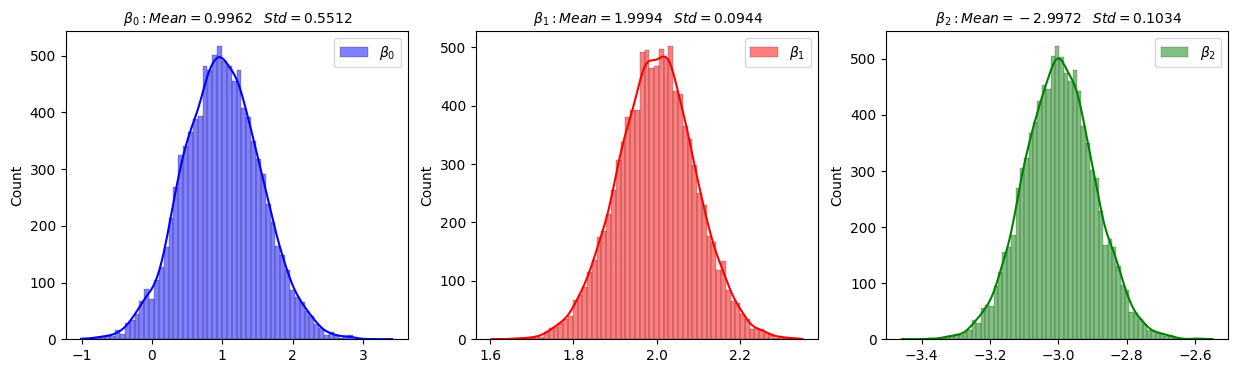

In [321]:
betas = small_sample_monte_carlo()

##### **2.2 Asymptotic versus Small Sample**
###### **For the model we studied so far, increase sample size from 60 to 10,000 and compare the distribution of estimated parameters.**

100%|██████████| 10000/10000 [00:06<00:00, 1557.75it/s]


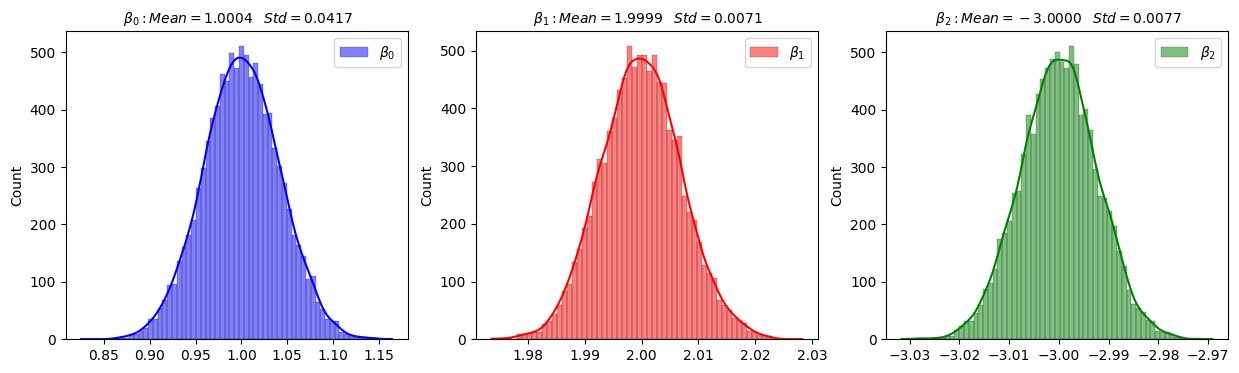

In [ ]:
betas = small_sample_monte_carlo(n=int(1e4)) #std drastically decreased

##### **2.3 True Size of Test**
###### **Hypothesis tests lead to either rejection or non-rejection of the null hypothesis. Correct decisions are made if $H_0$ is rejected when $H_0$ is false or if $H_0$ is not rejected when $H_0$ is true. There are also two possible incorrect decisions: (1) rejecting $H_0$ when $H_0$ is true, called a type I error, and (2) non-rejection of $H_0$ when $H_0$ is false, called a type II error. Ideally the probabilities of both errors will be low, but in practice decreasing the probability of one type of error comes at the expense of increasing the probability of the other. The classical hypothesis testing solution is to fix the probability of a type I error at a particular level, usually 0.05, while leaving the probability of a type II error unspecified. Define the size of a test or significance level $$ \alpha = 1 - Pr[type \; II \; error] = Pr[\, reject\; H_0 \,|\, H_{0} \; true] $$ The power of a test is defined to be $$Power = 1 - Pr[type \; II \; error] = Pr[\, reject\; H_0 \,|\, H_{\alpha} \; true]$$ Now think about the $10,000$ draw from the DGP and imagine that each time you want to test the null hypothesis that $\beta_1 = 2$. Each time you simulate the data, you may use t-test for this hypothesis. What is the true size and power of this test? If you know the distribution of the error terms you may find analytical solution for the power and size of the test. Or if you have large enough sample, you may use the asymptotic theories to determine the size of the test. The problem arises when neither are available. For instance, in this case you have only N = 60 observations, not large enough to use asymptotic properties, and you do not know the distrbution of the error term. Therefore, you need Monte Carlo Simulations to find the true size and power of the test.If you simulate the DGP enough times, then the true size or actual size of the test statistic is simply the fraction of replications for which the test statistic falls in the rejection region. Ideally, this is close to the nominal size, which is the chosen significance level of the test. For example, if testing at 5% the nominal test size is 0.05 and the true size is hopefully close to 0.05. The power of a test is calculated as the fraction of replications for that the null hypothesis is rejected.**

In [366]:
def hypothesis_testing(n, beta_index, alpha, hypothesis_value, r, plot_region = True):
    
    betas = small_sample_monte_carlo(n = n , r = r, plot=False)
    standard_normal_b = (betas[:,beta_index].get() - hypothesis_value) / (betas[:,beta_index].get().std())
    upper_acc = st.norm.ppf(1 - (alpha/2), loc=0, scale=1)
    lower_acc = st.norm.ppf(alpha/2, loc=0, scale=1)
    acceptance_region_probability = ((standard_normal_b>lower_acc) & ((standard_normal_b<upper_acc))).mean()

    if plot_region:
        sns.histplot(standard_normal_b, kde=True, stat='density')
        plt.axvline(x=lower_acc, color='green', ls='--')
        plt.axvline(x=upper_acc, color='green', ls='--')
        plt.axvspan(lower_acc, upper_acc, alpha=0.2, color='green')
        plt.title(f'Within acceptance region estimations = {acceptance_region_probability:.2%} \n True size = {1 - acceptance_region_probability:.2%}')
        plt.xlabel(f' $ \\beta_{beta_index} $')
        plt.show()

    return (1 - acceptance_region_probability)

100%|██████████| 10000/10000 [00:06<00:00, 1635.38it/s]


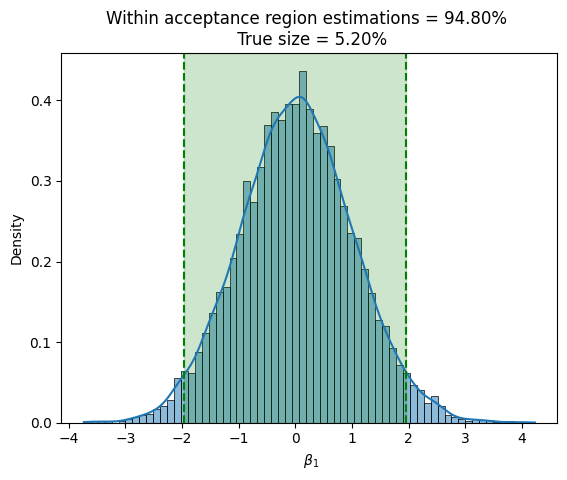

In [367]:
true_size = hypothesis_testing(n = 60, beta_index = 1, alpha = 5/100, hypothesis_value = 2, r = int(1e4) ,plot_region = True)

100%|██████████| 10000/10000 [00:06<00:00, 1506.76it/s]


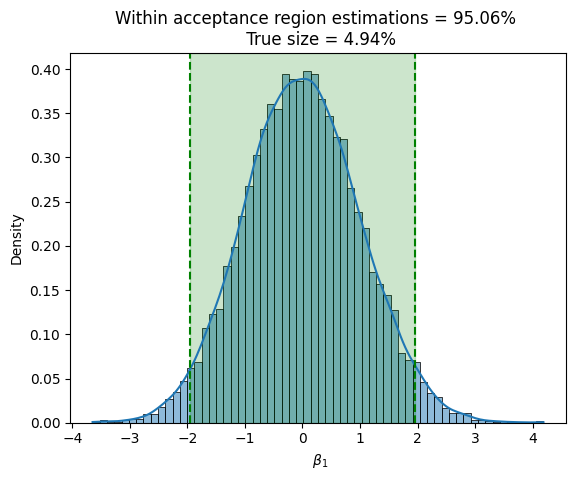

In [368]:
true_size = hypothesis_testing(n = int(1e4), beta_index = 1, alpha = 5/100, hypothesis_value = 2, r = int(1e4), plot_region = True)

##### **2.4 Number of Replications**
###### **Numerous simulations are needed to determine actual test size, because this depends on behavior in the tails of the distribution rather than the center. If $R$ simulations are run for a test of true size $\alpha$, then the proportion of times the null hypothesis is correctly rejected is an outcome from $R$ binomial trials with mean $\alpha$ and variance $\alpha (1-\alpha) / R $. Show that a mere 100 simulations is not enough for empirical true size since, for example, this interval is $(0.004, 0.096) \text{  when  } \alpha = 0.05$. For $10,000$ simulations the $95%$ interval is much more precise, equalling (0.008, 0.012), (0.046, 0.054), (0.094, 0.106), and (0.192, 0.208) for $\alpha$ equal to, respectively, 0.01, 0.05, 0.10, and 0.20. This is why in this example we used $R = 10,000$ simulations.**

In [377]:
true_sizes = []
for i in range(10):
    true_sizes.append(hypothesis_testing(n = 60, beta_index = 1, alpha = 5/100, hypothesis_value = 2, r = 100, plot_region = False)) 
print(f'Range of true sizes \\alpha = ({np.array(true_sizes).min():.4f},{np.array(true_sizes).max():.4f})')

100%|██████████| 100/100 [00:00<00:00, 1891.70it/s]

Range of true sizes \alpha = (0.0400,0.0800)


In [374]:
true_sizes = []
for i in range(10):
    true_sizes.append(hypothesis_testing(n = 60, beta_index = 1, alpha = 5/100, hypothesis_value = 2, r = 10_000, plot_region = False)) 
print(f'Range of true sizes \\alpha = ({np.array(true_sizes).min():.4f},{np.array(true_sizes).max():.4f})')

100%|██████████| 10000/10000 [00:07<00:00, 1392.32it/s]

Range of true sizes \alpha = (0.0492,0.0526)


##### **2.5 Endogeneity**
###### **So far, we assumed that $x_1$ and $x_2$ are exogenous. Here we will study the problem that arises from endogeneity. Imagine that there is an exogenous variable that affect both $x_2$ and the $y$. Think about wage regression, in which the left hand side variable is wage of workers and $x_2$ is years of schooling. We know that many unobservable factors1 such as ability, family properties,etc, a¤ect both. Call these variables z. Hence, imagine that the true data generating process is $$ x_1 \sim N(5,2)$$ $$z \sim Binomial(6,0.7)$$ $$x_2 \sim Binomial(4z,0.8)$$ $$\epsilon = 7z + \mu_2$$ $$ y = 1 + 2x_1 - 3x_2 + \epsilon$$ where $\mu_1$, $\mu_2$ and $\epsilon$ are assumed to independently drawn from standard normal distribution. However, you as the researcher, only observe $y,  x_1,  x_2$ for each worker. Repeat parts 1, 2 and 3 for this dgp.**

In [392]:
def small_sample_monte_carlo_endog(r=int(1e4), n=60, plot=True):
    
    b_s = cp.zeros((r, 3))

    for i in tqdm(range(r)):
        x_0 = cp.ones((n,1))
        x_1 = cp.random.normal(5, cp.sqrt(2), n)
        z = cp.random.binomial(6, 0.7, n)
        x_2 = cp.array([cp.random.binomial(4 * zi, 8, 1).item() for zi in z])
        e = 7 * z + cp.random.normal(0,1,n)
        y = 1 + 2*x_1 - 3*x_2 + e
        x = cp.concatenate((x_0 , x_1.reshape(-1,1), x_2.reshape(-1,1)), axis=-1)
        y = y.reshape(-1,1)
        b = cp.linalg.inv(x.T @ x) @ (x.T @ y)
        b_s[i] = b.flatten()
    
    if plot:
        plt.subplot(1,3,1)
        sns.histplot(b_s[:,0].get(), kde = True,  label=r'$\beta_0$', color='blue')
        plt.legend()
        plt.title(f' $ \\beta_0:  Mean = {b_s[:,0].get().mean():.4f}  \; \; \; Std = {b_s[:,0].get().std():.4f} $ ', fontsize = 10)
        
        
        plt.subplot(1,3,2)
        sns.histplot(b_s[:,1].get(), kde = True,  label=r'$\beta_1$', color='red')
        plt.legend()
        plt.title(f' $ \\beta_1:  Mean = {b_s[:,1].get().mean():.4f}  \; \; \; Std = {b_s[:,1].get().std():.4f} $ ', fontsize = 10)
        
        
        plt.subplot(1,3,3)
        sns.histplot(b_s[:,2].get(), kde = True,  label=r'$\beta_2$', color='green')
        plt.legend()
        plt.title(f' $ \\beta_2:  Mean = {b_s[:,2].get().mean():.4f}  \; \; \; Std = {b_s[:,2].get().std():.4f} $ ', fontsize = 10)
        
        
        
        plt.gcf().set_size_inches(15,4)
    
    return b_s


100%|██████████| 10000/10000 [01:17<00:00, 128.75it/s]


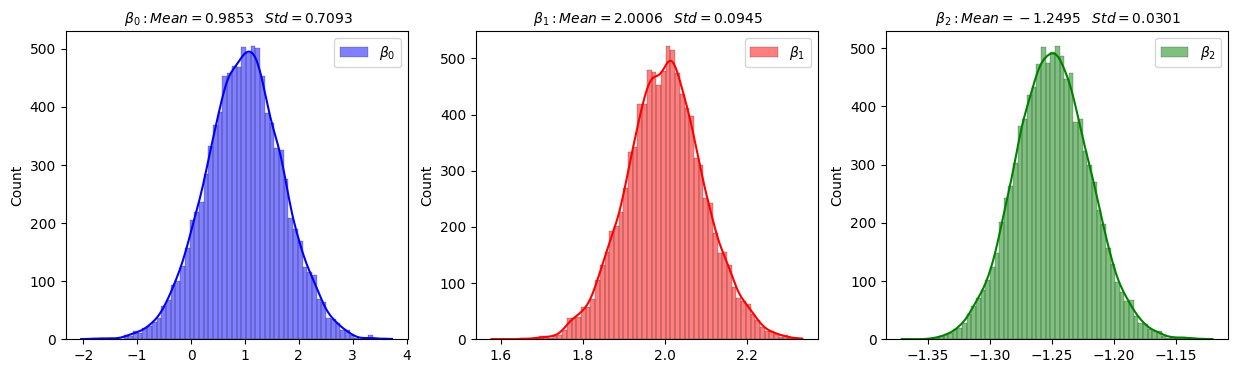

In [390]:
betas = small_sample_monte_carlo_endog()

100%|██████████| 10000/10000 [20:53<00:00,  7.98it/s]


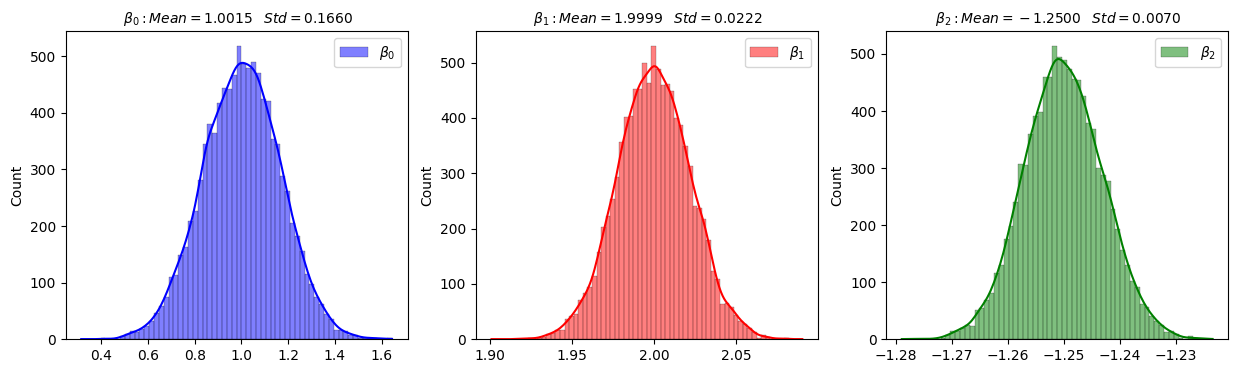

In [393]:
betas = small_sample_monte_carlo_endog(n=int(1e3)) #Endog will not be solved even with large samples

In [399]:
def hypothesis_testing_endog(n, beta_index, alpha, hypothesis_value, r, plot_region = True):
    
    betas = small_sample_monte_carlo_endog(n = n , r = r, plot=False)
    standard_normal_b = (betas[:,beta_index].get() - hypothesis_value) / (betas[:,beta_index].get().std())
    upper_acc = st.norm.ppf(1 - (alpha/2), loc=0, scale=1)
    lower_acc = st.norm.ppf(alpha/2, loc=0, scale=1)
    acceptance_region_probability = ((standard_normal_b>lower_acc) & ((standard_normal_b<upper_acc))).mean()

    if plot_region:
        sns.histplot(standard_normal_b, kde=True, stat='density')
        plt.axvline(x=lower_acc, color='green', ls='--')
        plt.axvline(x=upper_acc, color='green', ls='--')
        plt.axvspan(lower_acc, upper_acc, alpha=0.2, color='green')
        plt.title(f'Within acceptance region estimations = {acceptance_region_probability:.2%} \n True size = {1 - acceptance_region_probability:.2%}')
        plt.xlabel(f' $ \\beta_{beta_index} $')
        plt.show()

    return (1 - acceptance_region_probability), betas

##### **3. Simulator Class**
###### **Write a Simulator class in python that can run Monte-Carlo simulation for a given function using a determined pdf. Then inherit a Frequency Simulator class from your Simulator class that can run a frequency simulator. Finally inherit an Important Sampling Simulator class from your Simulator class that can run a Important Sampling Simulator.**

In [636]:
class MonteCarloSimulator():
    
    def __init__(self, sample_size, p_dist, p_params, h_func):

        self.sample_size = sample_size
        self.p_dist = p_dist
        self.p_params = p_params
        self.h_func = h_func
        self.sample = self.p_dist(*self.p_params).rvs(self.sample_size)
        self.p_dist = self.p_dist(*self.p_params).pdf

    def monte_carlo_sample(self):
        sample_monte_carlo = self.h_func(self.sample)
        return sample_monte_carlo
    
    def monte_carlo(self):
        return self.monte_carlo_sample().mean()
    
    def pdf_p_dist(self, x):
        return self.p_dist(x)

In [653]:
class FrequencySimulator(MonteCarloSimulator):
    def __init__(self,  sample_size, p_dist, p_params, h_func):
        super().__init__(sample_size, p_dist, p_params, h_func)
    def frequency_sim(self):
        return self.monte_carlo()

In [655]:
class ImportantSamplingSimulator(MonteCarloSimulator):
    def __init__(self, sample_size, p_dist, p_params, h_func):
        super().__init__(sample_size, p_dist, p_params, h_func)
    def importance_sampling_sim(self, pdf_g):
        h_u = self.monte_carlo_sample()
        p_u = self.pdf_p_dist(self.sample)
        g_u = pdf_g(self.sample)
        w_u = h_u * g_u / p_u
        return w_u.mean()

In [661]:
ImportantSamplingSimulator(1000000, st.norm, [5,2], lambda x: x**2).importance_sampling_sim(st.uniform(0,1).pdf)

0.33921925454957974

#### **4. Logit derivation**
##### **4.1 Gumbel distribution**
###### **Use the pdf and CDF function for Gumbel distribution to derive the following graph in Python. Recall that for type I extreme value (Gumbel) distribution we have: $$\huge g(x) = e^{-x} e^{-e^{-x}}$$ $$\huge G(x) = e^{-e^{-x}}$$ and mean is $\gamma$, the Euler-Mascheroni constant, and variance is $\dfrac{\pi^2}{3}$**

<Axes: ylabel='Density'>

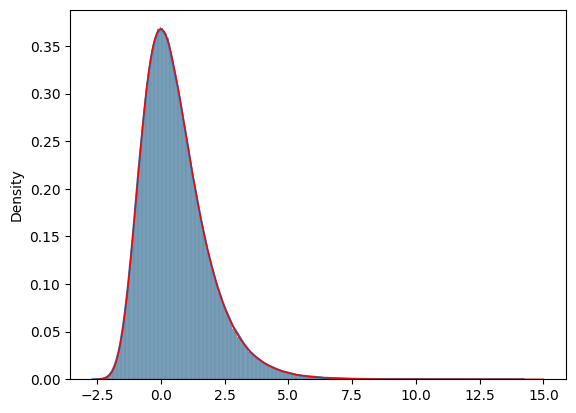

In [682]:
sns.histplot(np.random.gumbel(size = 1_000_000), kde=True, stat='density', fill=True)
x = np.linspace(-2.5,15,1_000_000)
sns.lineplot(x = x, y = np.exp(-x) * np.exp(-np.exp(-x)), color='red', lw=1)

##### **4.2 Gumbel - Gumbel = Logistics ~ Normal**

In [683]:
g_1 = np.random.gumbel(size = 1_000_000)
g_2 = np.random.gumbel(size = 1_000_000)
logistic = g_2 - g_1

<Axes: ylabel='Density'>

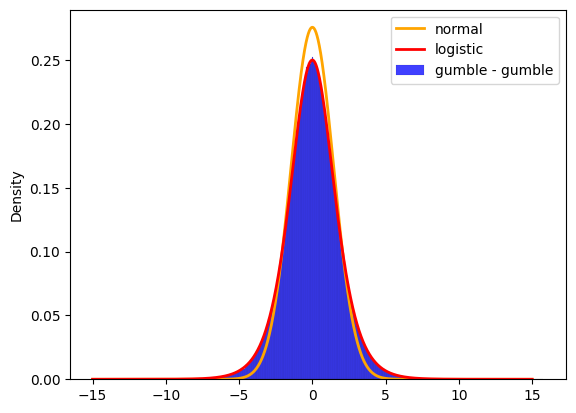

In [694]:
x = np.linspace(-15,15,1_000_000)
sns.histplot(logistic, label = 'gumble - gumble', stat='density', color = 'blue')
sns.lineplot(x=x, y = st.norm(0,np.sqrt(2*np.pi/3)).pdf(x), color = 'orange', lw=2, label = 'normal')
sns.lineplot(x=x, y = st.logistic().pdf(x), color = 'red', lw=2, label = 'logistic')